# Bragg reflection


-----------
Initializing structure...
time for choose_chunkdivision = 0.000447035 s
Working in 2D dimensions.
Computational cell is 30 x 3 x 0 with resolution 50


time for set_epsilon = 0.189583 s
-----------
Meep progress: 31.2/200.0 = 15.6% done in 4.0s, 21.6s to go
on time step 3120 (time=31.2), 0.00128223 s/step
Meep progress: 62.230000000000004/200.0 = 31.1% done in 8.0s, 17.7s to go
on time step 6224 (time=62.24), 0.00128889 s/step
Meep progress: 94.28/200.0 = 47.1% done in 12.0s, 13.5s to go
on time step 9430 (time=94.3), 0.00124798 s/step
Meep progress: 127.37/200.0 = 63.7% done in 16.0s, 9.1s to go
on time step 12740 (time=127.4), 0.00120883 s/step
Meep progress: 157.45000000000002/200.0 = 78.7% done in 20.0s, 5.4s to go
on time step 15749 (time=157.49), 0.00132996 s/step
Meep progress: 189.3/200.0 = 94.7% done in 24.0s, 1.4s to go
on time step 18936 (time=189.36), 0.00125524 s/step
run 0 finished at t = 200.0 (20000 timesteps)
     block, center = (-9.75,0,0)
          size (0.5,3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (-7.75,0,0)
          size (

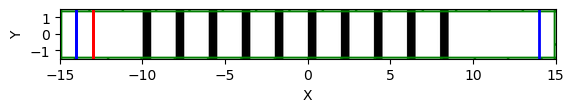

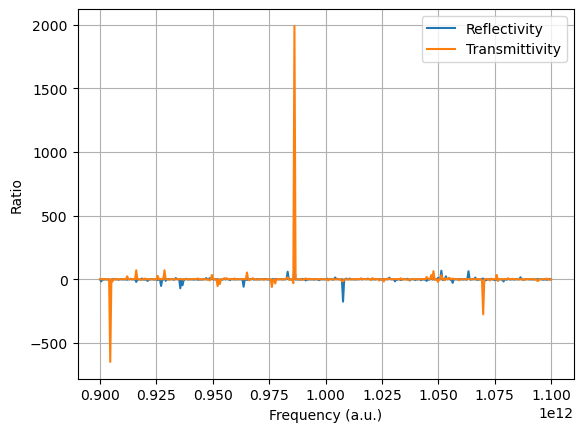

In [10]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 50
period = 1.0
num_periods = 10
d_high = 0.5
eps_high = 12
geometry_height = 3.0  
frequency = 1e12
observe_range = 0.1

cell_size = mp.Vector3(2*num_periods*period + 10, geometry_height, 0)

# =====================================
# 定义周期性矩形块（Bragg 光栅）
geometry = []
for i in range(num_periods):
    geometry.append(mp.Block(
        size=mp.Vector3(d_high, geometry_height, mp.inf),
        center=mp.Vector3(-num_periods*period + i*2*period + d_high/2),
        material=mp.Medium(epsilon=eps_high)
    ))

# =====================================
# 定义光源
sources = [mp.Source(mp.GaussianSource(frequency=frequency, fwidth=0.2),
                     component=mp.Ez,
                     center=mp.Vector3(-cell_size.x/2 + 2),
                     size=mp.Vector3(0, geometry_height))]

# =====================================
# 监测面
refl_fr = mp.FluxRegion(center=mp.Vector3(-cell_size.x/2 + 1),size=mp.Vector3(0, geometry_height))
tran_fr = mp.FluxRegion(center=mp.Vector3(cell_size.x/2 - 1),size=mp.Vector3(0, geometry_height))

# =====================================
# 先仿真空结构，记录 incident
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=[mp.PML(0.1)],
                    geometry=[],
                    sources=sources,
                    resolution=resolution,
                    dimensions=2)

incident_flux = sim.add_flux((1-observe_range)*frequency, (1+observe_range)*frequency, 400, refl_fr)
sim.plot2D()
sim.run(until=200)
incident_data = mp.get_fluxes(incident_flux)

# =====================================
# 再仿真实际 Bragg 结构
sim.reset_meep()
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=[mp.PML(0.1)],
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    dimensions=2)

refl_flux = sim.add_flux((1-observe_range)*frequency, (1+observe_range)*frequency, 400, refl_fr)
tran_flux = sim.add_flux((1-observe_range)*frequency, (1+observe_range)*frequency, 400, tran_fr)

sim.plot2D()
sim.run(until=200)

refl_data = mp.get_fluxes(refl_flux)
tran_data = mp.get_fluxes(tran_flux)

# =====================================
# 画反射透射谱
freqs = np.linspace((1-observe_range)*frequency, (1+observe_range)*frequency, 400)
R = -np.array(refl_data) / np.array(incident_data)
T = np.array(tran_data) / np.array(incident_data)

plt.figure()
plt.plot(freqs, R, label='Reflectivity')
plt.plot(freqs, T, label='Transmittivity')
plt.xlabel('Frequency (a.u.)')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.show()
